# Purpose of the Analysis: Building a prediction model for NSW Real Estate

## Purpose
The main objective here is to build a model that will predict the purchase price of a property with maximum possible accuracy.

This model can be used by the following parties:

1. Individual real property owners: Individuals owning an property and willing to sell it, can benefit from this model, as, properties can be sold in a competitive marketplace only if the asking price is at or less than the competitive market price. If the property is valaute at less than the market price then the owner will lose out on some money. On the other hand, if the asking price is more than the market price then people will not pay for this property.

4. Real estate companies: Real estate companies willing to deal properties in a particular location can easily predict what the rent will be given their specification. This will help the real estate companies evaluate the project before investing more accurately.

2. Business Owners: business owners who are looking to buy properties can more accurately do cost-benefit analysis before starting to look for places for their shops, warehouse or factories. 
 
## Hypothesis:
Regression models can accurately predict **property purchase price** using geographical information, property details, and settlement time. 

**I will be using linear regression model, and decision tree (regressor) to try to predict the property purchase price.**

# Data Introduction

This dataset was collected from Kaggle. Here is the link to the dataset: https://www.kaggle.com/datasets/josephcheng123456/nsw-australia-property-data/data

The person who shared this dataset in Kaggle, scrapped it from here: https://valuation.property.nsw.gov.au/embed/propertySalesInformation

NSW authority shares the prices of property sales on a weekly basis, but the shared datasets are in DAT format and compiled in thousands of files over hundreds of folders. It downloaded, cleaned and compiled into a csv format where the datasets included all the property sales data from 1990 to 2000 in one dataset and another data included property data from 2001 to 2024.

**Please note that the original 'nsw_property_data.csv' dataset had over 4.8 million datasets with a size of 600 MB+. I was working with that csv file, but while pushing github was giving me an error saying I can't push files with size over 100MB. Moreover, running machine learning models with original dataset was taking a lot time. So I trimmed the data before to reduce the dataset size**

# Data cleaning and preparation

In [1]:
#importing necessary libraries
import pandas as pd
import datetime
import numpy as np
import matplotlib.pylab as plt

In [2]:
#importing the trimmed dataset
property_data = pd.read_csv('nsw_property_data_new.csv')

## Data Exploration

In [3]:
#removing the index column, which was created in the last save
property_data.drop(columns = 'Unnamed: 0', inplace = True)

#viewing the first 5 rows and columns to get an idea of the idea
property_data.head()

,property_id,download_date,council_name,purchase_price,address,post_code,property_type,strata_lot_number,property_name,area,area_type,contract_date,settlement_date,zoning,nature_of_property,primary_purpose,legal_description
0,1672682.0,2024-02-19,BYRON,1120000.0,"129 MAFEKING RD, GOONENGERRY",2482.0,house,NaN,NaN,3.419,H,2024-01-19,2024-02-15,RU2,R,RESIDENCE,1/607703
1,1665192.0,2024-02-19,BYRON,2800000.0,"38 AVOCADO CRES, EWINGSDALE",2481.0,house,NaN,NaN,3420.000,M,2023-11-10,2024-02-15,R5,R,RESIDENCE,25/806200
2,1676023.0,2024-02-19,BYRON,1500000.0,"20 ROYAL AVE, SOUTH GOLDEN BEACH",2483.0,house,NaN,NaN,727.200,M,2023-11-17,2024-02-09,R2,R,RESIDENCE,213/31166
3,1670957.0,2024-02-19,BYRON,985000.0,"2 INDERWONG AVE, OCEAN SHORES",2483.0,house,NaN,NaN,992.700,M,2023-09-27,2024-02-12,R2,R,RESIDENCE,1101/241074
4,1673846.0,2024-02-19,BYRON,720000.0,"52 NAROOMA DR, OCEAN SHORES",2483.0,house,NaN,NaN,771.400,M,2024-02-06,2024-02-09,R2,R,RESIDENCE,337/238455


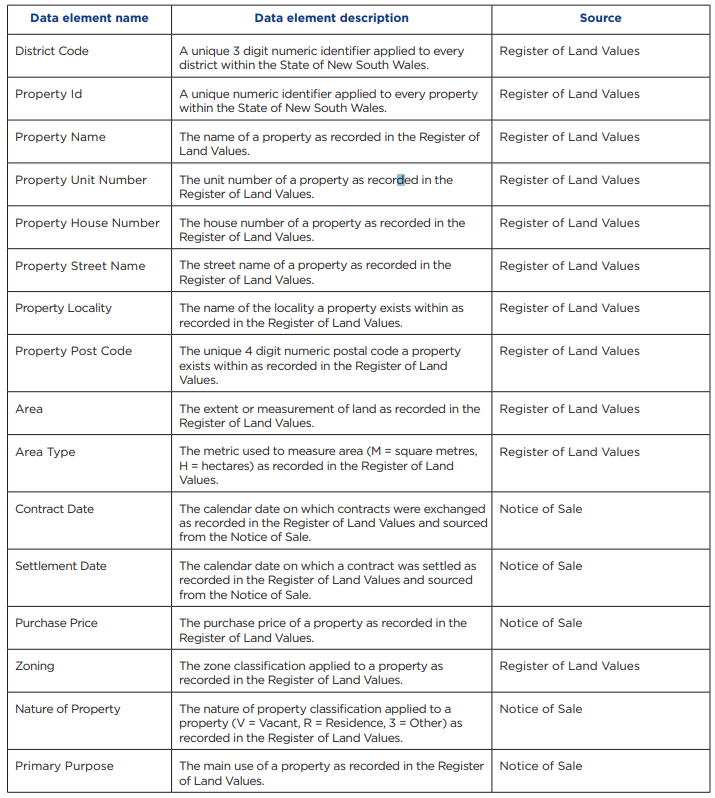

Source: https://www.valuergeneral.nsw.gov.au/__data/assets/pdf_file/0016/216403/Property_Sales_Data_File_-_Data_Elements_V3.pdf 

In [4]:
#checking the variable types of each of the columns
property_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638043 entries, 0 to 638042
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   property_id         637961 non-null  float64
 1   download_date       638043 non-null  object 
 2   council_name        638043 non-null  object 
 3   purchase_price      638043 non-null  float64
 4   address             638043 non-null  object 
 5   post_code           638038 non-null  float64
 6   property_type       638043 non-null  object 
 7   strata_lot_number   213012 non-null  float64
 8   property_name       20179 non-null   object 
 9   area                502902 non-null  float64
 10  area_type           502902 non-null  object 
 11  contract_date       638040 non-null  object 
 12  settlement_date     638043 non-null  object 
 13  zoning              394573 non-null  object 
 14  nature_of_property  638043 non-null  object 
 15  primary_purpose     637988 non-nul

In [5]:
#printing the null values for each column
property_data.isnull().sum()

property_id               82
download_date              0
council_name               0
purchase_price             0
address                    0
post_code                  5
property_type              0
strata_lot_number     425031
property_name         617864
area                  135141
area_type             135141
contract_date              3
settlement_date            0
zoning                243470
nature_of_property         0
primary_purpose           55
legal_description          0
dtype: int64

There are a lot of null values, with the highest number of null values being in the strata_lot_number column.

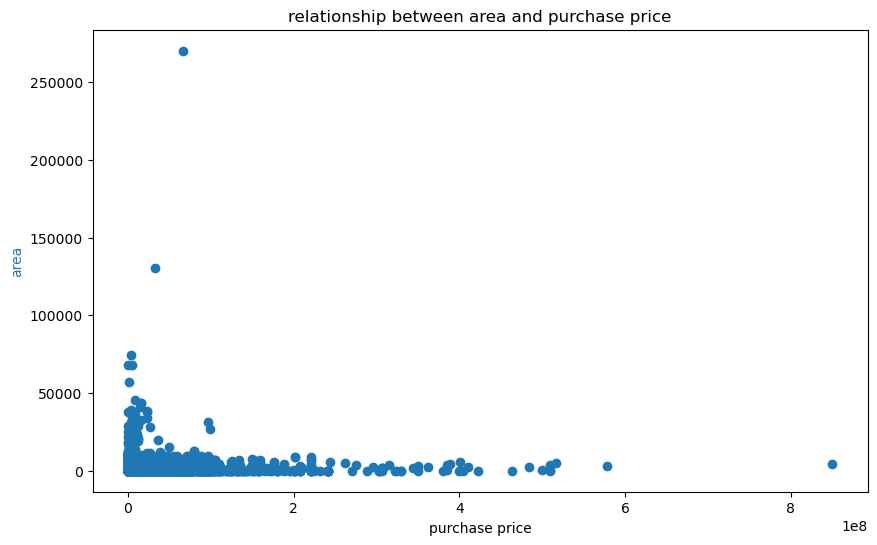

In [6]:
# Setting up the plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

#labels and titles
ax1.set_xlabel('purchase price')
ax1.set_ylabel('area', color='tab:blue')
plt.title('relationship between area and purchase price')

plt.scatter(property_data['purchase_price'], property_data['area'])

plt.show()

## Data Cleaning

Initially I tried converting the date columns to datetime datatype, but was getting errors while doing that. Below is a summary of which date columns were getting the errors and what the errors were.

In [7]:
#columns that have dates in it and will be converted
date_columns = ['contract_date', 'settlement_date', 'download_date']

#column name and what the error was will be saved in this error dictionary
error = {}


for date_column in date_columns:
    
    #try converting the column to pandas datetime datatype, if it fails fo to except
    try:
        property_data[date_column] = pd.to_datetime(property_data[date_column])
        
    #the conversion failed and the code will enter here
    #error is saved in variable 'e', which is later saved in the error dictionary along with column name
    except Exception as e:
        error[date_column] = e
        print(f'error in date column: {date_column}')

error in date column: contract_date


In [8]:
#print the error that caused the issue
print(error['contract_date'])

Out of bounds nanosecond timestamp: 1024-01-05 00:00:00, at position 341. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


Seems like a date from year 1024 was passed in contract date, and pandas only support last 570 or so years. But obviously this probably was an error while inputting the data. Lets try to see all the rows that have some sort of error.

In [9]:
#unlike the last conversion I have added errors = 'coerce' parameter. 
#as a result the error rows will be converted to NaT values (time not available)
property_data['contract_date_cleaned'] = pd.to_datetime(property_data['contract_date'], errors = 'coerce')

In [10]:
#rows where errors are present, and was converted to null values
# but the problem is that the originial contract-date column itself had null values
#so errors will be in rows where contract_date is not null but contract_date_cleaned is null
clenaed_contract_null_cond = property_data['contract_date_cleaned'].isnull()
raw_contract_not_null_cond = property_data['contract_date'].notnull()
contract_issues_cond = clenaed_contract_null_cond & raw_contract_not_null_cond


#printing the error rows
contract_issues = property_data[['contract_date_cleaned', 'contract_date']][contract_issues_cond]
contract_issues

,contract_date_cleaned,contract_date
1462,NaT,1024-01-05
7113,NaT,1023-11-20
76178,NaT,1022-10-04
97222,NaT,1022-12-23
99173,NaT,1022-05-05
99656,NaT,1022-10-05
122376,NaT,0222-04-29
130233,NaT,0225-05-22
172890,NaT,0222-02-01
197624,NaT,1022-06-08


These rows are clearly garbage data. and there is no way for me to know what the actual dates were. Moreover these rows constitute only a small portion of the whole dataset. Hence, I will be removing these rows.

In [11]:
#how many rows where this date issue is present = total_na_drops
length_before_na_drop = len(property_data)
length_after_na_drop = len(property_data[['contract_date_cleaned']].dropna())
total_na_drops = length_before_na_drop - length_after_na_drop

print(f'length_before_na_drop: {length_before_na_drop}')
print(f'length_after_na_drop: {length_after_na_drop}')
print(f'total_na_drops: {total_na_drops}')
print(f'percentage of rows with date issues: {round(total_na_drops/length_before_na_drop*100, 3)}%')

length_before_na_drop: 638043
length_after_na_drop: 638013
total_na_drops: 30
percentage of rows with date issues: 0.005%


length_before_na_drop: **638,043**

length_after_na_drop: **638,013**

Only 0.005% rows will be dropped

In [12]:
#dropping the rows with the mentioned errors
print(property_data.shape)

property_data = property_data[property_data['contract_date_cleaned'].notnull()]

print(property_data.shape)

(638043, 18)
(638013, 18)


#### Cleaning Null values in are column

In [13]:
property_data.loc[property_data['area'].isna(), 'area'] = property_data['area'].mean()

## Data Preparation

### Settlement Time

Contract date is the date when the legal contract between the two parties were exchanged, and settlement date is when the contract was finally settled by transfer of ownership (refer to the image in previous section). Here I will be using the difference between settlement and contract period in the model. 

In [14]:
#calcualtes the difference between settlement date and contract date
#then saves the difference in days in settlement_time column
property_data['settlement_time'] = property_data['settlement_date'] - property_data['contract_date_cleaned']

print(property_data['settlement_time'].describe())
property_data['settlement_time'].sort_values()

count                         638013
mean     107 days 22:02:57.096077978
std      410 days 05:15:55.427495524
min                  0 days 00:00:00
25%                 35 days 00:00:00
50%                 43 days 00:00:00
75%                 71 days 00:00:00
max              44691 days 00:00:00
Name: settlement_time, dtype: object


534167       0 days
602100       0 days
341532       0 days
341568       0 days
341581       0 days
            ...    
24156    37902 days
197179   38020 days
94111    38084 days
565824   44453 days
363882   44691 days
Name: settlement_time, Length: 638013, dtype: timedelta64[ns]

These output shows that generally 4 months have been taken to settle the contracts. But some contracts have taken over 40 thousand days to settle. There could have been very few cases out of million where a contract was made decades ago and contract itself stated that it will be transferred after decades. Or these are actually garbage data.

I am not going to do anything about this and keep the settlement period as it is due to my lack of knowledge and lack of information in the webstie.

In [15]:
#converting days to seconds to pass to the model
property_data['settlement_seconds'] = [timedelta.total_seconds() for timedelta in property_data['settlement_time']]

In [16]:
property_data[property_data['strata_lot_number'].notnull()]['strata_lot_number'].value_counts()

strata_lot_number
1.0       17435
2.0       17379
3.0       11984
4.0       10602
5.0        8843
          ...  
989.0         1
1002.0        1
840.0         1
695.0         1
786.0         1
Name: count, Length: 830, dtype: int64

In [17]:
#keeping the prepared data in model data dataframe
model_data = property_data.drop(columns = ['strata_lot_number', 'property_id', 'property_name'])

Strata lot numbers are arbitrary numbers given to each property inside a strata, and does not carry any information about the specification of the property. Hence I will remove it before running model. For the similar reason dropped property_id and property_name as well.

In [18]:
model_data['legal_description'].value_counts()

legal_description
70/SP106623    51
69/SP106623    50
65/SP106623    50
74/SP106623    49
72/SP106623    35
               ..
7/SP12272       1
12/SP1456       1
62/SP2245       1
17/SP2245       1
102//9998       1
Name: count, Length: 602284, dtype: int64

In [19]:
#dropping legal description column as the website did not have any details about this
model_data = model_data.drop(columns = 'legal_description')

In [20]:
#printing the variables and counts for zoning
print(model_data['zoning'].value_counts().head())

#how many unique variables are in zoning
model_data['zoning'].nunique()

zoning
R2     194370
R1      81113
R3      25760
RU1     17697
RU5     14714
Name: count, dtype: int64


57

57 are too many categories to be passed to the model. Hence removing this column as well.

In [21]:
model_data['post_code'].value_counts()

post_code
2765.0    12815
2155.0     7297
2170.0     6966
2179.0     6172
2570.0     5910
          ...  
2661.0        3
2678.0        2
2237.0        1
2432.0        1
2059.0        1
Name: count, Length: 621, dtype: int64

**Though postcode is a float type here, its actually not a continuous variable. As the difference between post 1 and 5 is not 4. Rather each number denotes a particular category**

In [22]:
model_data['council_name'].value_counts()

council_name
BLACKTOWN               30648
CENTRAL COAST           26695
CITY OF SYDNEY          23022
CITY OF PARRAMATTA      20989
CANTERBURY-BANKSTOWN    18109
                        ...  
BALRANALD                 224
CENTRAL DARLING           219
BREWARRINA                121
UNINCORPORATED AREA        56
211                         1
Name: count, Length: 130, dtype: int64

In [23]:
model_data['address'].value_counts()

address
117 BATHURST ST, SYDNEY                465
5 MANCHESTER DR, SCHOFIELDS            166
38 HANNELL ST, WICKHAM                 136
125 JERRALONG DR, SCHOFIELDS           105
71 MACQUARIE ST, SYDNEY                 93
                                      ... 
155 GEORGE ST, ERSKINEVILLE              1
59/3 ERSKINEVILLE RD, NEWTOWN            1
317/6 CRESCENT ST, REDFERN               1
5/233 DARLINGHURST RD, DARLINGHURST      1
2 PERTH AVE, LINDFIELD                   1
Name: count, Length: 590837, dtype: int64

For the same reason as zoning column, removing post_code, address, and council_name columns as well. Moreover there are other columns that gives us geographical details which is covered in the next sectiion.

In [24]:
model_data = model_data.drop(columns = ['zoning', 'post_code', 'address', 'council_name'])

In [25]:
#finally dropping the contract and settlement dates as i will only be using the difference between these two dates
model_data = model_data.drop(columns = ['contract_date', 'settlement_date', 'contract_date_cleaned', 'download_date', 'settlement_time'])

In [26]:
model_data.head()

,purchase_price,property_type,area,area_type,nature_of_property,primary_purpose,settlement_seconds
0,1120000.0,house,3.419,H,R,RESIDENCE,2332800.0
1,2800000.0,house,3420.000,M,R,RESIDENCE,8380800.0
2,1500000.0,house,727.200,M,R,RESIDENCE,7257600.0
3,985000.0,house,992.700,M,R,RESIDENCE,11923200.0
4,720000.0,house,771.400,M,R,RESIDENCE,259200.0


### Label Encoding

**Labelling all the categorical variables that have low number of categories**

In [27]:
#label encoder will be used to encode categorical variables into 0 and 1, 1 will be in rows where its true
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [28]:
property_data['primary_purpose'].value_counts()

primary_purpose
RESIDENCE         541771
VACANT LAND        59056
COMMERCIAL         16711
FARM               10720
WAREHOUSE           2544
                   ...  
COMMERCIAL UNI         1
UNINHABITABLE          1
PART BUILT             1
EXISTING               1
SCHOOL                 1
Name: count, Length: 174, dtype: int64

In [29]:
#naming all the purposes that are not in top 10 in terms of frequency
primary_purpose_top10 = list(property_data['primary_purpose'].value_counts().head(10).index)
model_data.loc[~model_data['primary_purpose'].isin(primary_purpose_top10), 'primary_purpose'] = 'other_purpose'

In [30]:
#converting all the categories in primary purpose into a column with values 0 and 1
model_data = pd.concat([model_data, pd.get_dummies(model_data['primary_purpose'], dtype = int)], axis = 1)
model_data.head()

,purchase_price,property_type,area,area_type,nature_of_property,primary_purpose,settlement_seconds,CARSPACE,COMMERCIAL,FACTORY,FARM,MARINE BERTH,OFFICE,RESIDENCE,SHOP,VACANT LAND,WAREHOUSE,other_purpose
0,1120000.0,house,3.419,H,R,RESIDENCE,2332800.0,0,0,0,0,0,0,1,0,0,0,0
1,2800000.0,house,3420.000,M,R,RESIDENCE,8380800.0,0,0,0,0,0,0,1,0,0,0,0
2,1500000.0,house,727.200,M,R,RESIDENCE,7257600.0,0,0,0,0,0,0,1,0,0,0,0
3,985000.0,house,992.700,M,R,RESIDENCE,11923200.0,0,0,0,0,0,0,1,0,0,0,0
4,720000.0,house,771.400,M,R,RESIDENCE,259200.0,0,0,0,0,0,0,1,0,0,0,0


In [31]:
model_data['nature_of_property'].value_counts()

nature_of_property
R    541773
V     59056
3     37184
Name: count, dtype: int64

In [32]:
model_data['nature_of_property'] = model_data['nature_of_property'].replace({'3': 'other_nature', 'R': 'residence_nature', 'V': 'vacant_nature'})

In [33]:
model_data = pd.concat([model_data, pd.get_dummies(model_data['nature_of_property'], dtype = int)], axis = 1)
model_data.columns

Index(['purchase_price', 'property_type', 'area', 'area_type',
       'nature_of_property', 'primary_purpose', 'settlement_seconds',
       'CARSPACE', 'COMMERCIAL', 'FACTORY', 'FARM', 'MARINE BERTH', 'OFFICE',
       'RESIDENCE', 'SHOP', 'VACANT LAND', 'WAREHOUSE', 'other_purpose',
       'other_nature', 'residence_nature', 'vacant_nature'],
      dtype='object')

Property type tells me whether a property is a house or an unit.

In [34]:
model_data['property_type'].value_counts()

property_type
house    433581
unit     204432
Name: count, dtype: int64

In [35]:
model_data = pd.concat([model_data, pd.get_dummies(model_data['property_type'], dtype = int)], axis = 1)
model_data.columns

Index(['purchase_price', 'property_type', 'area', 'area_type',
       'nature_of_property', 'primary_purpose', 'settlement_seconds',
       'CARSPACE', 'COMMERCIAL', 'FACTORY', 'FARM', 'MARINE BERTH', 'OFFICE',
       'RESIDENCE', 'SHOP', 'VACANT LAND', 'WAREHOUSE', 'other_purpose',
       'other_nature', 'residence_nature', 'vacant_nature', 'house', 'unit'],
      dtype='object')

In [36]:
model_data['area_type'].value_counts()

area_type
M    460690
H     42189
Name: count, dtype: int64

In [37]:
model_data = pd.concat([model_data, pd.get_dummies(model_data['area_type'], dtype = int)], axis = 1)
model_data.columns

Index(['purchase_price', 'property_type', 'area', 'area_type',
       'nature_of_property', 'primary_purpose', 'settlement_seconds',
       'CARSPACE', 'COMMERCIAL', 'FACTORY', 'FARM', 'MARINE BERTH', 'OFFICE',
       'RESIDENCE', 'SHOP', 'VACANT LAND', 'WAREHOUSE', 'other_purpose',
       'other_nature', 'residence_nature', 'vacant_nature', 'house', 'unit',
       'H', 'M'],
      dtype='object')

dropping all the categorical columns that have been labeled.

In [38]:
model_data = model_data.drop(columns = ['property_type', 'area_type', 'nature_of_property', 'primary_purpose'])

In [39]:
#now no null values remain
model_data.isna().sum()

purchase_price        0
area                  0
settlement_seconds    0
CARSPACE              0
COMMERCIAL            0
FACTORY               0
FARM                  0
MARINE BERTH          0
OFFICE                0
RESIDENCE             0
SHOP                  0
VACANT LAND           0
WAREHOUSE             0
other_purpose         0
other_nature          0
residence_nature      0
vacant_nature         0
house                 0
unit                  0
H                     0
M                     0
dtype: int64

In [40]:
model_data.shape

(638013, 21)

# Predictive Modeling

## Correlation Analysis

In [41]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

In [42]:
model_data.corr()['purchase_price'].sort_values()

residence_nature     -0.062459
RESIDENCE            -0.062457
unit                 -0.026759
vacant_nature        -0.026224
VACANT LAND          -0.026224
M                    -0.021934
CARSPACE             -0.005964
settlement_seconds   -0.003922
MARINE BERTH         -0.002343
FACTORY               0.007355
OFFICE                0.011763
house                 0.026759
WAREHOUSE             0.036791
area                  0.036858
SHOP                  0.037065
FARM                  0.038930
H                     0.075505
other_purpose         0.096104
COMMERCIAL            0.105059
other_nature          0.127859
purchase_price        1.000000
Name: purchase_price, dtype: float64

All variables have very low correlation against purchase price. Though all the correlation values are low, I am removing ones that are even lower compared to others (basically the middle section)

## Train and test split

In [43]:
#all the columns with extremely low correlation and purchase price (which is the target variable) has been dropped in x 
#y has purchase price
x = model_data.drop(columns = ['purchase_price', 'unit', 'vacant_nature', 'M', 'CARSPACE', 'settlement_seconds',
                              'MARINE BERTH', 'FACTORY', 'OFFICE', 'house'])
y = model_data['purchase_price']

x = x.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=11)

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(574211, 11)
(574211,)
(63802, 11)
(63802,)


training data has been set to be 90% of the total size of the data

In [45]:
print(X_train.shape)

(574211, 11)


## Building Linear Regression Model

In [46]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

#calculating mse, root mse and r-square to evaluate the models
predicted = reg.predict(X_test) 

mse = ((np.array(y_test)-predicted)**2).sum()/len(y_test)
root_mse = np.sqrt(mse)
r2_lr = r2_score(y_test, predicted)

print(f'For linear regression:\n MSE: {mse}\n Root MSE: {root_mse}\n R-Squared: {r2_lr}')

For linear regression:
 MSE: 23878029552745.4
 Root MSE: 4886515.072395193
 R-Squared: 0.040487708182458726


In [47]:
mse/y.mean()

17313965.45952204

As expected the R-square is value low. 
MSE and Root MSE (both lower the better) are extremely high. For comparison, MSE is 17 million times the mean of purchase price.

## Decision Tree

Now I have explore if other models can predict the house prices better using the given predictors.

In [48]:
from sklearn.tree import DecisionTreeRegressor

#decision tree model training for purchase data prediction
clf_default = DecisionTreeRegressor(random_state=42)
clf_default.fit(X_train, y_train)

#model evaluation with testing data
y_pred = clf_default.predict(X_test)

In [49]:
mse = ((np.array(y_test)-y_pred)**2).sum()/len(y_test)
root_mse = np.sqrt(mse)
r2_dt = r2_score(y_test, y_pred)

print(f'For Decision Tree:\n MSE: {mse}\n Root MSE: {root_mse}\n R-Squared: {r2_dt}')

For Decision Tree:
 MSE: 30541659317624.03
 Root MSE: 5526450.878965996
 R-Squared: -0.227282907202643


In [50]:
mse/y.mean()

22145765.140869126

## Findings

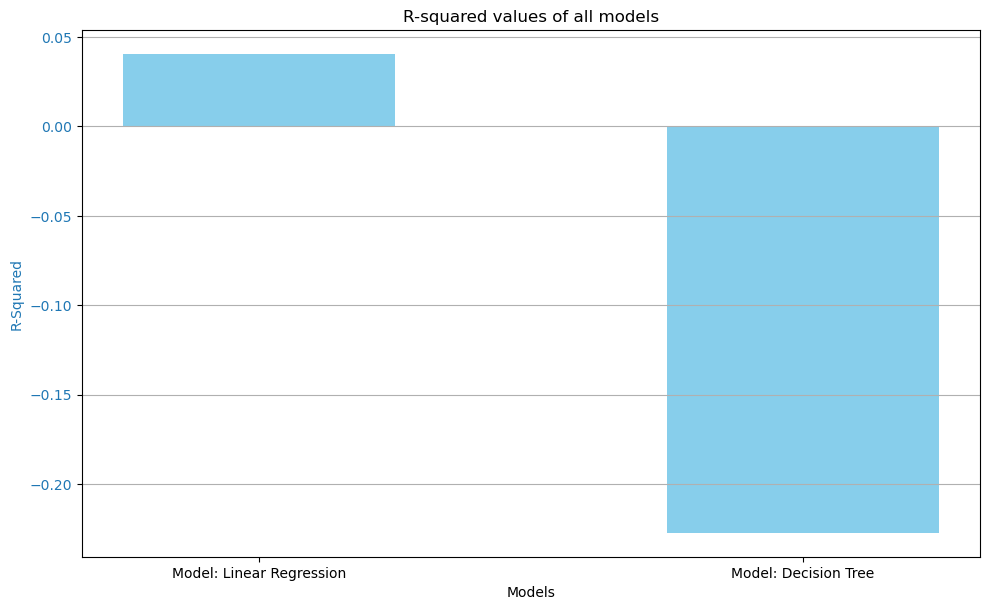

In [51]:
# Model performance data
models = ['Model: Linear Regression', 
          'Model: Decision Tree']
r2_values = [r2_lr, r2_dt]

# Setting up the plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First axis for r-square
ax1.set_xlabel('Models')
ax1.set_ylabel('R-Squared', color='tab:blue')
ax1.bar(models, r2_values, color='skyblue', width=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Legend, title and grid
fig.tight_layout()
plt.grid(True, axis = 'y')
plt.title('R-squared values of all models')

plt.show()

Decision tree has performed worse than the linear regression model. The performance of this model is so bad that the R-squared value here is negative. **The negative R-squared value indicates that if the purchase price was predicted using the mean, it would have performed better than this model"

The probable reason decision tree has performed worse could be that: Decision trees can be very sensitive to noise in the data. If there is a lot of noise, the tree might try to fit this noise, leading to worse performance. Linear regression, being a more rigid model, might be less affected by noise and thus perform better.

## Conclusion

The analysis highlights the importance of feature selection in predictive modeling and demonstrates the effectiveness of logistic regression and KNN in classifying mobile price ranges. The comparison between models based on accuracy revealed that while logistic regression showed higher accuracy on the test set, KNN, with its robust cross-validation, was preferred due to better generalization.


The linear regression model is recommended for predicting property purchase prices (this dataset only, for other dataset the scenarion might be different based on the dynamics of the data) due to its robustness and higher performance metrics. This model provides a more reliable basis for property valuation compared to decision tree models, which may overfit noisy data.